In [ ]:
!jupyter nbconvert --to script Root_Clustering.ipynb

[NbConvertApp] Converting notebook Root_Clustering.ipynb to script
[NbConvertApp] Writing 34729 bytes to Root_Clustering.py


In [1]:
# ✅ STEP 1: Fresh clone of the repo (avoid nesting errors)
!rm -rf quran_analysis
!git clone https://github.com/Diqzi-D/quran_analysis.git
%cd quran_analysis/Root\ Clustering

# ✅ STEP 2: Smart download helper
from pathlib import Path

def smart_download(path, url):
    path = Path(path)
    if not path.exists():
        print(f"📥 Downloading: {path.name}")
        path.parent.mkdir(parents=True, exist_ok=True)
        !wget -q "{url}" -O "{path}"
        print(f"✅ Downloaded to: {path}")
    else:
        print(f"✅ Already exists: {path}")

# ✅ STEP 3: Smart download any large file needed
# (Only use this block if your current notebook depends on a large file)
# Example:
# smart_download(
#     "Data/merged_quran_data.csv",
#     "https://github.com/Diqzi-D/quran_analysis/releases/download/v1.0/merged_quran_data.csv"
# )

# ✅ STEP 4: Confirm working directory and contents
from os import getcwd
print("📂 Current directory:", getcwd())
!ls -l

Cloning into 'quran_analysis'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 114 (delta 3), reused 3 (delta 0), pack-reused 100 (from 3)
Receiving objects: 100% (114/114), 147.69 MiB | 18.30 MiB/s, done.
Resolving deltas: 100% (24/24), done.
Updating files: 100% (64/64), done.
/content/quran_analysis/Root Clustering
📂 Current directory: /content/quran_analysis/Root Clustering
total 1024
drwxr-xr-x 2 root root    4096 Apr  8 13:16 Data
drwxr-xr-x 2 root root    4096 Apr  8 13:16 Output
-rw-r--r-- 1 root root 1036963 Apr  8 13:16 Root_Clustering.ipynb


In [2]:
# 📦 Core Libraries
!pip install numpy pandas matplotlib seaborn scikit-learn

# 📊 NLP + Arabic Tools
!pip install arabic-reshaper python-bidi adjustText

# 🧠 Embedding / Clustering / Visualization
!pip install umap-learn

# 🔽 For Google Drive file download (optional, for big files)
!pip install gdown


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.9/292.9 kB 10.5 MB/s eta 0:00:00


In [3]:
# Helper to reshape Arabic for correct visualization
import arabic_reshaper
from bidi.algorithm import get_display

def reshape_arabic(text):
    reshaped = arabic_reshaper.reshape(text)
    return get_display(reshaped)

In [5]:
# StopWord List

import json

# --- Load Stop Words ---
stop_words_file = "Data/stop_words_arabic.txt"  # Replace with your actual path
with open(stop_words_file, "r", encoding="utf-8") as file:
    stop_words = set(word.strip() for word in file if word.strip())

# --- Load Normalized Unified Quran Data ---
input_file = "Data/normalized_unified_quran_data.json"
with open(input_file, "r", encoding="utf-8") as f:
    normalized_data = json.load(f)

# --- Function to Filter Stopwords from Roots ---
def filter_stopwords_in_roots(data, stop_words):
    """
    For each verse, filters out stop words from the 'arabic_roots' field.
    Adds two new keys:
      - 'filtered_roots': roots that are not stopwords.
      - 'filtered_out_roots': roots that were filtered out.
    """
    filtered_data = []
    for verse in data:
        # Retrieve roots; default to an empty list if missing
        roots = verse.get("arabic_roots", [])
        filtered_roots = [root for root in roots if root not in stop_words]
        filtered_out = [root for root in roots if root in stop_words]
        verse["filtered_roots"] = filtered_roots
        verse["filtered_out_roots"] = filtered_out
        filtered_data.append(verse)
    return filtered_data

# --- Apply Stopword Filtering ---
filtered_data = filter_stopwords_in_roots(normalized_data, stop_words)

# --- Save the Filtered Data ---
output_file = "Data/filtered_unified_quran_data.json"
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(filtered_data, f, ensure_ascii=False, indent=4)

print("✅ Filtered data saved to:", output_file)


✅ Filtered data saved to: Data/filtered_unified_quran_data.json


In [6]:
# All Roots Co-Occurrence

import json
from collections import Counter, defaultdict

# --- Load the Normalized Unified Data ---
input_file = "Data/filtered_unified_quran_data.json"
with open(input_file, "r", encoding="utf-8") as file:
    normalized_data = json.load(file)

# --- Function to Perform Co-Occurrence Analysis on Roots ---
def co_occurrence_analysis(data, threshold=2, key="filtered_roots"):
    """
    Analyzes the co-occurrence of roots within each verse.

    Parameters:
      data (list): List of verse entries.
      threshold (int): Minimum number of occurrences for a pair to be included.
      key (str): The key in each verse that holds the list of roots (default "filtered_roots").

    Returns:
      dict: A dictionary mapping each root to a Counter of co-occurring roots.
    """
    cooccurrence_counts = defaultdict(Counter)

    # Build the co-occurrence matrix
    for verse in data:
        # Retrieve the list of roots safely; default to empty list if key is missing.
        roots = verse.get(key, [])
        if not isinstance(roots, list):
            continue
        # For each pair of distinct roots in the verse, update the count
        for i, root1 in enumerate(roots):
            for j, root2 in enumerate(roots):
                if i != j:
                    cooccurrence_counts[root1][root2] += 1

    # Apply the threshold filter: keep only pairs with count >= threshold
    filtered_cooccurrence_counts = {
        root: {
            co_root: count
            for co_root, count in connections.items() if count >= threshold
        }
        for root, connections in cooccurrence_counts.items()
    }
    return filtered_cooccurrence_counts

# --- Perform Co-Occurrence Analysis ---
filtered_cooccurrence_counts = co_occurrence_analysis(normalized_data, threshold=2, key="filtered_roots")

# --- Save the Filtered Co-Occurrence Data to JSON ---
output_file = "Data/filtered_cooccurrence_data.json"
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(filtered_cooccurrence_counts, f, ensure_ascii=False, indent=4)

print(f"\n✅ Co-occurrence analysis saved to {output_file}")

# --- Print a Sorted Sample of Co-Occurrence Results ---
print("\n🔹 First 5 Co-Occurrence Results:")
for root, cooccurrences in list(filtered_cooccurrence_counts.items())[:5]:
    print(f"Root: {root}")
    sorted_cooccurrences = sorted(cooccurrences.items(), key=lambda x: x[1], reverse=True)
    for co_root, count in sorted_cooccurrences:
        print(f"  ↪ Co-occurs with: {co_root}, Count: {count}")



✅ Co-occurrence analysis saved to Data/filtered_cooccurrence_data.json

🔹 First 5 Co-Occurrence Results:
Root: سمو
  ↪ Co-occurs with: اله, Count: 319
  ↪ Co-occurs with: ارض, Count: 263
  ↪ Co-occurs with: علم, Count: 111
  ↪ Co-occurs with: قول, Count: 110
  ↪ Co-occurs with: اللذ, Count: 98
  ↪ Co-occurs with: كون, Count: 95
  ↪ Co-occurs with: خلق, Count: 93
  ↪ Co-occurs with: شيا, Count: 82
  ↪ Co-occurs with: ربب, Count: 77
  ↪ Co-occurs with: هو, Count: 75
  ↪ Co-occurs with: سمو, Count: 64
  ↪ Co-occurs with: كلل, Count: 64
  ↪ Co-occurs with: نزل, Count: 59
  ↪ Co-occurs with: بين, Count: 56
  ↪ Co-occurs with: ملك, Count: 47
  ↪ Co-occurs with: راي, Count: 41
  ↪ Co-occurs with: قوم, Count: 38
  ↪ Co-occurs with: موه, Count: 35
  ↪ Co-occurs with: ايا, Count: 34
  ↪ Co-occurs with: اتي, Count: 33
  ↪ Co-occurs with: اجل, Count: 33
  ↪ Co-occurs with: يوم, Count: 33
  ↪ Co-occurs with: جعل, Count: 32
  ↪ Co-occurs with: قدر, Count: 32
  ↪ Co-occurs with: امن, Count: 31
  ↪ C

In [7]:
# Config Root

specific_root = "صلح"  # Change this value as needed

In [8]:
# Specific Root co-occurrence + Total Frequency Count

import json

# --- Load Filtered Co-Occurrence Data ---
cooccurrence_file = "Data/filtered_cooccurrence_data.json"
with open(cooccurrence_file, "r", encoding="utf-8") as f:
    filtered_cooccurrence_counts = json.load(f)

# --- Load Unified Quran Data to Count Root Occurrences ---
quran_data_file = "Data/filtered_unified_quran_data.json"  # Adjust if needed
with open(quran_data_file, "r", encoding="utf-8") as f:
    quran_verses = json.load(f)

# --- Count Total Occurrences and Unique Verses ---
total_occurrences = 0
verse_occurrences = 0
for verse in quran_verses:
    roots = verse.get("arabic_roots", [])  # or use "filtered_roots"
    count_in_verse = roots.count(specific_root)
    if count_in_verse > 0:
        total_occurrences += count_in_verse
        verse_occurrences += 1

print(f"\n📌 Root '{specific_root}' appears {total_occurrences} times in total.")
print(f"📌 It appears in {verse_occurrences} unique verses.")

# --- Extract Co-occurrence Data and Save ---
if specific_root in filtered_cooccurrence_counts:
    print(f"\n🔹 Co-Occurrence Data for Stem: {specific_root}")

    sorted_cooccurrences = sorted(
        filtered_cooccurrence_counts[specific_root].items(),
        key=lambda x: x[1],
        reverse=True
    )

    specific_root_data = {
        "stem": specific_root,
        "total_occurrences": total_occurrences,
        "verse_occurrences": verse_occurrences,
        "cooccurrences": [
            {"co-stem": co_stem, "count": count} for co_stem, count in sorted_cooccurrences
        ]
    }

    specific_root_file = f"Output/{specific_root}_cooccurrence.json"
    with open(specific_root_file, "w", encoding="utf-8") as f:
        json.dump(specific_root_data, f, ensure_ascii=False, indent=4)

    print(f"✅ Co-occurrence data saved to: {specific_root_file}")

    # --- Preview ---
    print("\n🔹 Top Co-Occurrences:")
    for entry in specific_root_data["cooccurrences"]:
        print(f"  ↪ Co-stem: {entry['co-stem']}, Count: {entry['count']}")
else:
    print(f"⚠ No co-occurrence data found for stem: {specific_root}")



📌 Root 'صلح' appears 180 times in total.
📌 It appears in 170 unique verses.

🔹 Co-Occurrence Data for Stem: صلح
✅ Co-occurrence data saved to: Output/صلح_cooccurrence.json

🔹 Top Co-Occurrences:
  ↪ Co-stem: عمل, Count: 118
  ↪ Co-stem: اله, Count: 114
  ↪ Co-stem: امن, Count: 102
  ↪ Co-stem: اللذ, Count: 95
  ↪ Co-stem: ربب, Count: 46
  ↪ Co-stem: كون, Count: 43
  ↪ Co-stem: قول, Count: 38
  ↪ Co-stem: حسن, Count: 27
  ↪ Co-stem: جنن, Count: 26
  ↪ Co-stem: دخل, Count: 26
  ↪ Co-stem: اجر, Count: 25
  ↪ Co-stem: توب, Count: 24
  ↪ Co-stem: بين, Count: 24
  ↪ Co-stem: رحم, Count: 24
  ↪ Co-stem: صلح, Count: 22
  ↪ Co-stem: غفر, Count: 21
  ↪ Co-stem: قوم, Count: 19
  ↪ Co-stem: هو, Count: 19
  ↪ Co-stem: سوا, Count: 19
  ↪ Co-stem: اتي, Count: 18
  ↪ Co-stem: كفر, Count: 18
  ↪ Co-stem: رسل, Count: 17
  ↪ Co-stem: وقي, Count: 16
  ↪ Co-stem: عبد, Count: 16
  ↪ Co-stem: تحت, Count: 15
  ↪ Co-stem: اخر, Count: 15
  ↪ Co-stem: نفس, Count: 15
  ↪ Co-stem: خير, Count: 15
  ↪ Co-stem: ظلم,

In [9]:
# Co-Occured Variation Tokens

import json

# --- Load the Specific Stem Co-occurrence Data ---
with open(f"Output/{specific_root}_cooccurrence.json", "r", encoding="utf-8") as f:
    specific_root_data = json.load(f)

# --- Load the Normalized Unified Data ---
with open("Data/normalized_unified_quran_data.json", "r", encoding="utf-8") as f:
    normalized_data = json.load(f)

# --- Extract Unique Arabic Tokens and Verses for Each Co-occurring Stem ---
# Dictionaries to store:
#   - co_stem_to_tokens: a set of unique tokens for each co-occurring stem
#   - co_stem_to_verses: a list of verses (with IDs and full text) where that co-stem appears
co_stem_to_tokens = {}
co_stem_to_verses = {}

# First, extract the list of co-occurring stems from the specific stem data
cooccurring_stems = [entry["co-stem"] for entry in specific_root_data["cooccurrences"]]

# Process each verse in the normalized data
for verse in normalized_data:
    # Only consider verses that contain the specific stem (e.g., "صلح")
    roots = verse.get("arabic_roots", [])
    tokens = verse.get("normalized_tokens", [])
    if specific_root not in roots:
        continue

    # Retrieve verse data using the correct keys
    verse_text = verse.get("text", "").strip()
    surah = verse.get("surah", "Unknown")
    verse_number = verse.get("verse", "Unknown")
    verse_id = f"Surah {surah}, Verse {verse_number}"
    verse_info = f"ID: {verse_id} -> {verse_text}"

    # Loop over tokens and their corresponding roots in the verse
    for token, root in zip(tokens, roots):
        if root in cooccurring_stems:
            # Record the token
            if root not in co_stem_to_tokens:
                co_stem_to_tokens[root] = set()
            co_stem_to_tokens[root].add(token)

            # Record the verse info (avoiding duplicates)
            if root not in co_stem_to_verses:
                co_stem_to_verses[root] = []
            if verse_info not in co_stem_to_verses[root]:
                co_stem_to_verses[root].append(verse_info)

# Convert each token set to a sorted list for JSON compatibility
co_stem_to_tokens = {k: sorted(list(v)) for k, v in co_stem_to_tokens.items()}

# --- Update the Specific Stem Data with the Tokens ---
specific_root_data["co_occurring_tokens"] = co_stem_to_tokens

# --- Save the Updated Specific Stem Data ---
output_file = f"Output/{specific_root}_cooccurrence_with_tokens.json"
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(specific_root_data, f, ensure_ascii=False, indent=4)

print(f"✅ Specific stem co-occurrence data with tokens saved to {output_file}")

# --- Print Preview (Tokens Only) ---
print("\n🔹 Unique Arabic Tokens for Each Co-occurring Stem:")
for co_stem, tokens in co_stem_to_tokens.items():
    print(f"Co-stem: {co_stem} -> Tokens: {tokens}")

# --- Create a Text Output File with Verses ---
txt_output_file = f"Output/{specific_root}_cooccurrence_tokens_and_verses.txt"
with open(txt_output_file, "w", encoding="utf-8") as f:
    for co_stem in sorted(co_stem_to_tokens.keys()):
        tokens_list = co_stem_to_tokens[co_stem]
        verses_list = co_stem_to_verses.get(co_stem, [])
        f.write(f"Co-stem: {co_stem} -> Tokens: {tokens_list}\n")
        f.write("          -> verses:\n")
        for verse in verses_list:
            f.write(f"             {verse}\n")
        f.write("\n")

print(f"✅ Text output saved to '{txt_output_file}'")


✅ Specific stem co-occurrence data with tokens saved to Output/صلح_cooccurrence_with_tokens.json

🔹 Unique Arabic Tokens for Each Co-occurring Stem:
Co-stem: قول -> Tokens: ['فقل', 'فيقول', 'قائلها', 'قال', 'قالوا', 'قل', 'قولا', 'قولها', 'قيل', 'قيلا', 'وسنقول', 'وقال', 'وقالوا', 'وقيل']
Co-stem: فسد -> Tokens: ['المفسد', 'المفسدين', 'تفسدوا', 'كالمفسدين', 'يفسدون']
Co-stem: ارض -> Tokens: ['ارض', 'ارضا', 'الارض', 'والارض']
Co-stem: صلح -> Tokens: ['اصلاح', 'اصلاحا', 'اصلاحها', 'الاصلاح', 'الصالح', 'الصالحات', 'الصالحون', 'الصالحين', 'المصلح', 'المصلحين', 'بالصالحين', 'تصلحوا', 'صالح', 'صالحا', 'صالحين', 'صلح', 'صلحا', 'فاصلح', 'فاصلحوا', 'فالصالحات', 'مصلحون', 'واصلح', 'واصلحا', 'واصلحنا', 'واصلحوا', 'والصالحين', 'والصلح', 'وتصلحوا', 'وصالح', 'ويصلح', 'ياصالح', 'يصلح', 'يصلحا', 'يصلحون']
Co-stem: بشر -> Tokens: ['بشر', 'مبشرين', 'وبشر', 'وبشرناه', 'ويبشر', 'يبشر', 'يبشرك']
Co-stem: اللذ -> Tokens: ['الذي', 'الذين', 'بالذي', 'فالذين', 'كالذين', 'للذين', 'والذين']
Co-stem: امن -> Token

In [10]:
# Co-occurred Root Embeddings

import json
import numpy as np

cooccurrence_file = f"Output/{specific_root}_cooccurrence.json"
embedding_file = "Data/final_root_embeddings.json"

# --- Load Embeddings ---
with open(embedding_file, "r", encoding="utf-8") as f:
    all_embeddings = json.load(f)

# --- Load Co-occurrence Data ---
with open(cooccurrence_file, "r", encoding="utf-8") as f:
    co_data = json.load(f)

# --- Collect all relevant roots: main root + co-occurring ones ---
related_roots = {specific_root}
related_roots.update([entry["co-stem"] for entry in co_data.get("cooccurrences", [])])

# --- Extract embeddings for the selected roots ---
filtered_roots = []
filtered_embeddings = []

for root in related_roots:
    embedding = all_embeddings.get(root)
    if embedding:
        filtered_roots.append(root)
        filtered_embeddings.append(embedding)

filtered_embeddings = np.array(filtered_embeddings)

# --- Save for later clustering ---
np.save(f"Output/{specific_root}_embeddings_with_cooccur.npy", filtered_embeddings)
with open(f"Output/{specific_root}_roots_with_cooccur.json", "w", encoding="utf-8") as f:
    json.dump(filtered_roots, f, ensure_ascii=False, indent=4)

print(f"✅ Extracted {len(filtered_roots)} roots for '{specific_root}' including co-occurrences.")
print(f"🔹 Saved embeddings to '{specific_root}_embeddings_with_cooccur.npy'")
print(f"🔹 Saved root names to '{specific_root}_roots_with_cooccur.json'")


✅ Extracted 248 roots for 'صلح' including co-occurrences.
🔹 Saved embeddings to 'صلح_embeddings_with_cooccur.npy'
🔹 Saved root names to 'صلح_roots_with_cooccur.json'


In [11]:
# Dimension Reduction

import umap
import numpy as np
import os
import json

# --- Configuration ---
input_embedding_file = f"Output/{specific_root}_embeddings_with_cooccur.npy"
output_embedding_file = f"Output/{specific_root}_reduced_embeddings_with_cooccur.npy"
roots_file = f"Output/{specific_root}_roots_with_cooccur.json"  # optional file with root names

# --- Load Embeddings ---
if not os.path.exists(input_embedding_file):
    raise FileNotFoundError(f"Embedding file not found: {input_embedding_file}")

embeddings = np.load(input_embedding_file)
print(f"✅ Loaded embeddings for root '{specific_root}' with shape {embeddings.shape}")

# --- Determine Number of Roots ---
# Option 1: Use the roots file if it exists
if os.path.exists(roots_file):
    with open(roots_file, "r", encoding="utf-8") as f:
        roots = json.load(f)
    num_roots = len(roots)
    print(f"✅ Loaded {num_roots} roots from '{roots_file}'")
else:
    # Option 2: Fallback to using the number of rows in the embeddings
    num_roots = embeddings.shape[0]
    print("⚠️ Roots file not found, using embeddings shape as count.")

# --- Set n_reduced_dimensions ---
if num_roots >= 100:
    n_reduced_dimensions = 100
else:
    n_reduced_dimensions = num_roots - 3

if n_reduced_dimensions < 1:
    raise ValueError("Computed n_reduced_dimensions is less than 1. Check your data.")

print(f"Setting n_reduced_dimensions to: {n_reduced_dimensions}")

# --- Apply UMAP for Dimensionality Reduction ---
umap_reducer = umap.UMAP(n_components=n_reduced_dimensions, random_state=42)
reduced_embeddings = umap_reducer.fit_transform(embeddings)

# --- Save Reduced Embeddings ---
np.save(output_embedding_file, reduced_embeddings)
print(f"✅ Saved reduced embeddings to '{output_embedding_file}'")

# --- Summary ---
print(f"Original dimensions: {embeddings.shape[1]}")
print(f"Reduced dimensions: {reduced_embeddings.shape[1]} (via UMAP with n_components={n_reduced_dimensions})")

✅ Loaded embeddings for root 'صلح' with shape (248, 768)
✅ Loaded 248 roots from 'Output/صلح_roots_with_cooccur.json'
Setting n_reduced_dimensions to: 100


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ Saved reduced embeddings to 'Output/صلح_reduced_embeddings_with_cooccur.npy'
Original dimensions: 768
Reduced dimensions: 100 (via UMAP with n_components=100)


✅ Loaded reduced embeddings with shape (248, 100) from 'Output/صلح_reduced_embeddings_with_cooccur.npy'.
✅ Loaded 248 roots from 'Output/صلح_roots_with_cooccur.json'.


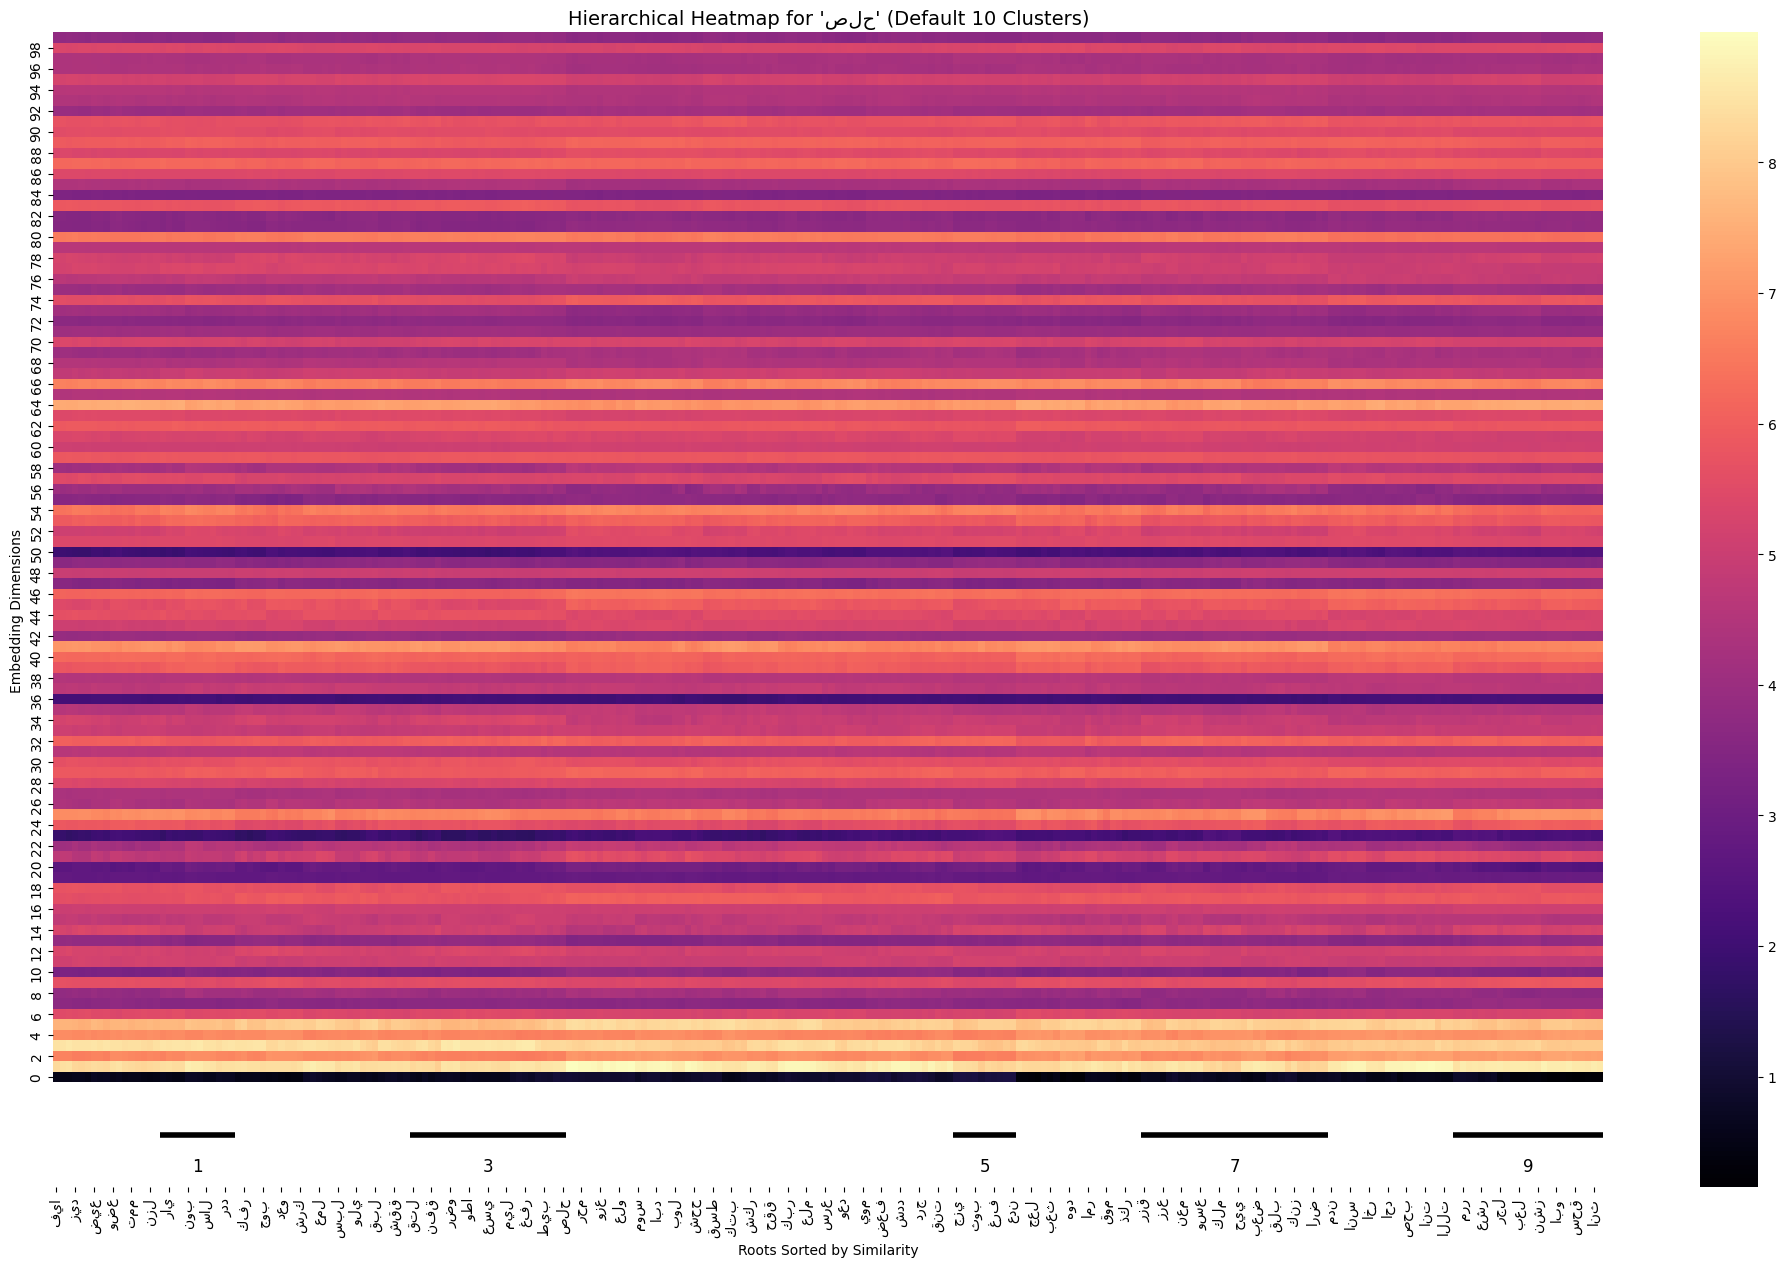

Enter desired number of clusters based on the above visualization (press Enter to keep default of 10): 20


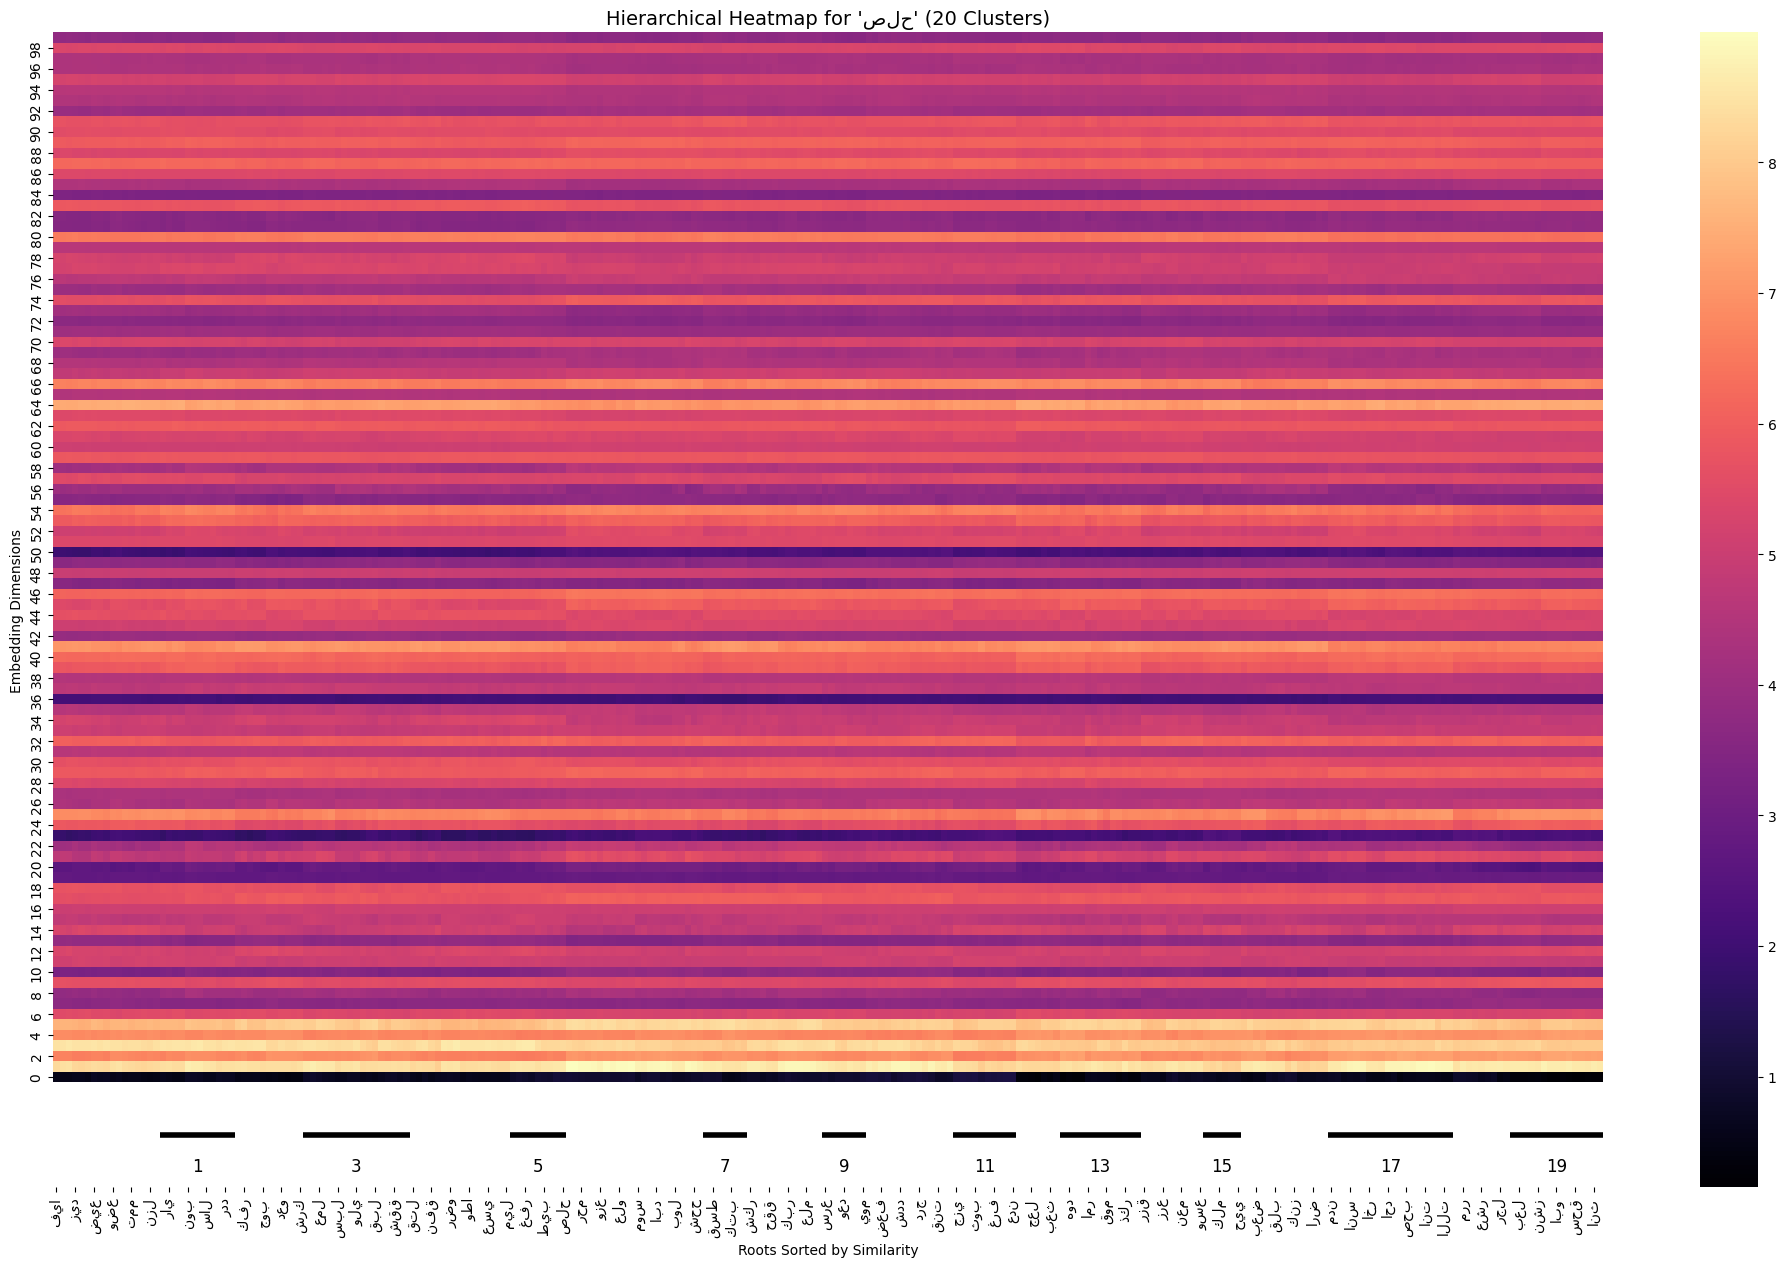

✅ Final heatmap saved to 'Output/صلح_hierarchical_clustered_heatmap.png'.
✅ Saved hierarchical clustering results to 'Output/صلح_hierarchical_clusters.json'.


In [14]:
# Hierarchical Clustering Heatmap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy.cluster.hierarchy import linkage, fcluster, leaves_list
import os

# --- Config ---
embedding_file = f"Output/{specific_root}_reduced_embeddings_with_cooccur.npy"
roots_file = f"Output/{specific_root}_roots_with_cooccur.json"
heatmap_output = f"Output/{specific_root}_hierarchical_clustered_heatmap.png"
cluster_json_output = f"Output/{specific_root}_hierarchical_clusters.json"
default_clusters = 10  # Default clustering value for initial visualization

# --- Load Reduced Embeddings ---
if not os.path.exists(embedding_file):
    raise FileNotFoundError(f"Embedding file '{embedding_file}' not found.")

embeddings = np.load(embedding_file)
print(f"✅ Loaded reduced embeddings with shape {embeddings.shape} from '{embedding_file}'.")

# --- Load Root Labels ---
with open(roots_file, "r", encoding="utf-8") as f:
    roots = json.load(f)
print(f"✅ Loaded {len(roots)} roots from '{roots_file}'.")

if len(roots) != embeddings.shape[0]:
    print("⚠ Number of roots does not match embedding count. Generating default labels.")
    roots = [f"Root {i+1}" for i in range(embeddings.shape[0])]

# --- Hierarchical Clustering ---
linkage_matrix = linkage(embeddings, method='ward')
ordered_indices = leaves_list(linkage_matrix)

# Compute default cluster labels (for visual inspection)
cluster_labels_default = fcluster(linkage_matrix, default_clusters, criterion='maxclust')
sorted_labels_default = cluster_labels_default[ordered_indices]

# --- Reorder Everything Based on Clustering ---
sorted_embeddings = embeddings[ordered_indices]
sorted_roots = [roots[i] for i in ordered_indices]

# --- Prepare Heatmap Data ---
heatmap_data = pd.DataFrame(sorted_embeddings, index=sorted_roots)

# --- Plot Heatmap with Default Clusters (for inspection only) ---
plt.figure(figsize=(25, 15))
ax = sns.heatmap(heatmap_data.T, cmap="magma")
ax.set_title(f"Hierarchical Heatmap for '{specific_root}' (Default {default_clusters} Clusters)", fontsize=14)
ax.set_xlabel("Roots Sorted by Similarity")
ax.set_ylabel("Embedding Dimensions")

# Draw cluster boundaries for default clusters
cluster_boundaries = []
prev_label = sorted_labels_default[0]
for i, label in enumerate(sorted_labels_default):
    if label != prev_label:
        cluster_boundaries.append(i)
        prev_label = label
cluster_boundaries.append(len(sorted_roots))

line_colors = ["black", "white"]
for i in range(len(cluster_boundaries) - 1):
    start = cluster_boundaries[i]
    end = cluster_boundaries[i + 1]
    ax.hlines(-5, start, end, colors=line_colors[i % 2], linewidth=4)
    ax.text((start + end) / 2, -8, f"{i+1}", ha="center", va="center", fontsize=12, color=line_colors[i % 2])

ax.set_xlim([0, len(sorted_roots)])
ax.set_ylim([-10, heatmap_data.shape[1]])
plt.show()
plt.close()

# --- Ask User for New Number of Clusters ---
user_input = input(f"Enter desired number of clusters based on the above visualization (press Enter to keep default of {default_clusters}): ")
if user_input.strip() == "":
    final_clusters = default_clusters
else:
    try:
        final_clusters = int(user_input)
    except ValueError:
        print(f"Invalid input. Using default value of {default_clusters}.")
        final_clusters = default_clusters

# --- Recompute Cluster Labels Using User-Defined Number ---
cluster_labels = fcluster(linkage_matrix, final_clusters, criterion='maxclust')
sorted_labels = cluster_labels[ordered_indices]

# --- Replot Final Heatmap with Updated Clusters ---
plt.figure(figsize=(25, 15))
ax = sns.heatmap(heatmap_data.T, cmap="magma")
ax.set_title(f"Hierarchical Heatmap for '{specific_root}' ({final_clusters} Clusters)", fontsize=14)
ax.set_xlabel("Roots Sorted by Similarity")
ax.set_ylabel("Embedding Dimensions")

# Draw updated cluster boundaries
cluster_boundaries = []
prev_label = sorted_labels[0]
for i, label in enumerate(sorted_labels):
    if label != prev_label:
        cluster_boundaries.append(i)
        prev_label = label
cluster_boundaries.append(len(sorted_roots))

for i in range(len(cluster_boundaries) - 1):
    start = cluster_boundaries[i]
    end = cluster_boundaries[i + 1]
    ax.hlines(-5, start, end, colors=line_colors[i % 2], linewidth=4)
    ax.text((start + end) / 2, -8, f"{i+1}", ha="center", va="center", fontsize=12, color=line_colors[i % 2])

ax.set_xlim([0, len(sorted_roots)])
ax.set_ylim([-10, heatmap_data.shape[1]])

# Save only the final heatmap to the output file
plt.savefig(heatmap_output, dpi=600, bbox_inches="tight")
plt.show()
plt.close()
print(f"✅ Final heatmap saved to '{heatmap_output}'.")

# --- Save Human-Readable Cluster Assignments ---
clusters = {}
for i, label in enumerate(sorted_labels):
    cluster_key = f"Cluster {label}"
    clusters.setdefault(cluster_key, []).append(sorted_roots[i])

with open(cluster_json_output, "w", encoding="utf-8") as f:
    json.dump(clusters, f, ensure_ascii=False, indent=4)
print(f"✅ Saved hierarchical clustering results to '{cluster_json_output}'.")


In [15]:
# Scatter Plot

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import json
import os
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
import arabic_reshaper
from bidi.algorithm import get_display
from adjustText import adjust_text

# ---------------------------
# 1. Setup filenames
# ---------------------------
embedding_file = f"output/{specific_root}_reduced_embeddings_with_cooccur.npy"
roots_file = f"output/{specific_root}_roots_with_cooccur.json"
cooccurrence_file = f"output/{specific_root}_cooccurrence.json"
clusters_file = f"output/{specific_root}_hierarchical_clusters.json"

# ---------------------------
# 2. Load data files
# ---------------------------
if os.path.exists(embedding_file):
    embeddings = np.load(embedding_file)
    print(f"✅ Loaded embeddings from '{embedding_file}' with shape {embeddings.shape}")
    # Check if the number of dimensions is below 50.
    if embeddings.shape[1] < 50:
        print(f"⚠ Reduced dimensions ({embeddings.shape[1]}) below 50, switching to original embeddings.")
        embedding_file = f"output/{specific_root}_embeddings_with_cooccur.npy"
        if os.path.exists(embedding_file):
            embeddings = np.load(embedding_file)
            print(f"✅ Loaded original embeddings from '{embedding_file}' with shape {embeddings.shape}")
        else:
            raise FileNotFoundError(f"Original embeddings file not found: '{embedding_file}'")
else:
    raise FileNotFoundError(f"Embeddings file not found: '{embedding_file}'")

with open(roots_file, "r", encoding="utf-8") as f:
    roots_list = json.load(f)

with open(cooccurrence_file, "r", encoding="utf-8") as f:
    co_data = json.load(f)

# Load co-stem frequencies and include total_occurrences of the specific root
root_frequencies = {entry["co-stem"]: entry["count"] for entry in co_data.get("cooccurrences", [])}
if "total_occurrences" in co_data:
    root_frequencies[specific_root] = co_data["total_occurrences"]
    print(f"📊 Total frequency of '{specific_root}': {co_data['total_occurrences']}")
else:
    root_frequencies[specific_root] = 1
    print(f"⚠ '{specific_root}' total_occurrences not found, fallback = 1")

with open(clusters_file, "r", encoding="utf-8") as f:
    cluster_data = json.load(f)

# ---------------------------
# 3. Build cluster mappings
# ---------------------------
root_to_cluster = {}
for label, stems_dict in cluster_data.items():
    try:
        cluster_id = int(label.split()[1])
    except:
        cluster_id = -1
    for root in stems_dict:
        root_to_cluster[root] = cluster_id

# ---------------------------
# 4. Filter roots to plot
# ---------------------------
valid_roots, valid_indices, frequencies, cluster_ids = [], [], [], []
for i, root in enumerate(roots_list):
    if root in root_to_cluster and root in root_frequencies:
        valid_roots.append(root)
        valid_indices.append(i)
        frequencies.append(root_frequencies[root])
        cluster_ids.append(root_to_cluster[root])
    else:
        print(f"⚠ Skipping '{root}' — missing cluster or frequency")

if not valid_indices:
    raise ValueError("No valid roots to plot.")

# ---------------------------
# 5. Dimensionality Reduction (Stable Layout)
# ---------------------------
selected_embeddings = embeddings[valid_indices]
distance_matrix = squareform(pdist(selected_embeddings, metric="euclidean"))

# --- User Input for TSNE Parameters ---
default_perplexity = min(30, max(2, len(valid_indices) - 1))
print(f"Current perplexity: {default_perplexity}")
user_input_perplexity = input(f"Enter desired perplexity (default {default_perplexity}): ")
if user_input_perplexity.strip() == "":
    perplexity = default_perplexity
else:
    try:
        perplexity = float(user_input_perplexity)
        # Ensure perplexity is within valid range
        if perplexity < 2:
            perplexity = 2
        elif perplexity > len(valid_indices) - 1:
            perplexity = len(valid_indices) - 1
    except Exception as e:
        print("Invalid input. Using default perplexity.")
        perplexity = default_perplexity
print(f"Using perplexity: {perplexity}")

tsne = TSNE(
    n_components=2,
    metric="precomputed",
    init="random",  # required with precomputed distance matrix
    random_state=42,
    perplexity=perplexity,
    max_iter=500
)
tsne_coords = tsne.fit_transform(distance_matrix)
print("✅ TSNE completed. TSNE coordinates shape:", tsne_coords.shape)

# --- Option 1: Normalize and Expand with Padding ---
x = tsne_coords[:, 0]
y = tsne_coords[:, 1]

# Center around 0 and scale to [-0.6, 0.6]
x = (x - x.mean()) / (x.ptp()) * 1.2
y = (y - y.mean()) / (y.ptp()) * 1.2

# Translate to [0, 1] with padding
x = x - x.min()
y = y - y.min()
x = x / x.max()
y = y / y.max()

norm_coords = np.column_stack((x, y))

# ---------------------------
# 5b. Repulsion-Based Spacing Adjustment (Soft Relaxation)
# ---------------------------
def apply_min_distance_spacing(coords, min_dist=0.02, steps=10, lr=0.01):
    coords = coords.copy()
    for step in range(steps):
        for i in range(len(coords)):
            for j in range(i + 1, len(coords)):
                dx, dy = coords[i] - coords[j]
                dist = np.sqrt(dx**2 + dy**2)
                if dist < min_dist:
                    force = (min_dist - dist) * lr
                    direction = np.array([dx, dy]) / (dist + 1e-5)
                    coords[i] += direction * force
                    coords[j] -= direction * force
        # Normalize again to [0, 1] each step to keep it bounded
        coords = coords - coords.min(axis=0)
        coords = coords / coords.max(axis=0)
    return coords

norm_coords = apply_min_distance_spacing(norm_coords, min_dist=0.04, steps=20, lr=0.06)
print("✅ Coordinates adjusted with repulsion spacing.")

# ---------------------------
# 6. Cluster Colors
# ---------------------------
unique_clusters = sorted(set(cluster_ids))
cmap = plt.get_cmap("gist_ncar", len(unique_clusters))

def luminance(color):  # perceived brightness
    r, g, b = mcolors.to_rgb(color)
    return 0.2126 * r + 0.7152 * g + 0.0722 * b

def darken(color, factor=0.7):
    return tuple(np.clip(factor * c, 0, 1) for c in mcolors.to_rgb(color))

def adjust_color(color, threshold=0.65):
    return darken(color) if luminance(color) > threshold else color

cluster_to_color = {cid: adjust_color(cmap(i)) for i, cid in enumerate(unique_clusters)}

# ---------------------------
# 7. Scatter Plot with User-Defined Text Parameters
# ---------------------------
# Ask for base_fontsize and scale_factor
default_base_fontsize = 5
default_scale_factor = 0.2
print(f"Current base_fontsize: {default_base_fontsize}, scale_factor: {default_scale_factor}")
user_base_fontsize = input(f"Enter desired base_fontsize (default {default_base_fontsize}): ")
if user_base_fontsize.strip() == "":
    base_fontsize = default_base_fontsize
else:
    try:
        base_fontsize = float(user_base_fontsize)
    except Exception as e:
        print("Invalid input. Using default base_fontsize.")
        base_fontsize = default_base_fontsize

user_scale_factor = input(f"Enter desired scale_factor (default {default_scale_factor}): ")
if user_scale_factor.strip() == "":
    scale_factor = default_scale_factor
else:
    try:
        scale_factor = float(user_scale_factor)
    except Exception as e:
        print("Invalid input. Using default scale_factor.")
        scale_factor = default_scale_factor

print(f"Using base_fontsize: {base_fontsize}, scale_factor: {scale_factor}")

plt.figure(figsize=(10, 8))
texts = []

for i, (x, y) in enumerate(norm_coords):
    root = valid_roots[i]
    freq = frequencies[i]
    cid = cluster_ids[i]

    font_size = base_fontsize + scale_factor * freq
    label = get_display(arabic_reshaper.reshape(root))
    color = cluster_to_color.get(cid, "black")
    text = plt.text(x, y, label, fontsize=font_size, color=color, alpha=0.85)
    texts.append(text)

adjust_text(
    texts,
    only_move={'text': 'xy'},
    force_text=70,
    force_points=0.7,
    expand_text=(1.05, 1.2),
    expand_points=(1.05, 1.2),
    arrowprops=dict(arrowstyle="-", color='grey', lw=0.5, alpha=0.0)
)

title_ar = get_display(arabic_reshaper.reshape(specific_root))
plt.title(f"Scatter Plot of Roots Co-occurring with '{title_ar}'", fontsize=16)
plt.xlabel("t-SNE X")
plt.ylabel("t-SNE Y")
plt.grid(True)
plt.xlim(0, 1)
plt.ylim(0, 1)

output_file = f"output/{specific_root}_scatter_cooccur_roots.png"
plt.savefig(output_file, dpi=600, bbox_inches="tight")
plt.show()
print(f"✅ Saved final plot to '{output_file}'")


FileNotFoundError: Embeddings file not found: 'output/صلح_reduced_embeddings_with_cooccur.npy'

✅ Loaded embeddings: (648, 100)
📊 Total frequency of 'امن': 879
Using perplexity: 10.0
✅ Coordinates adjusted with repulsion spacing.
Using base_fontsize: 3.0, scale_factor: 0.05


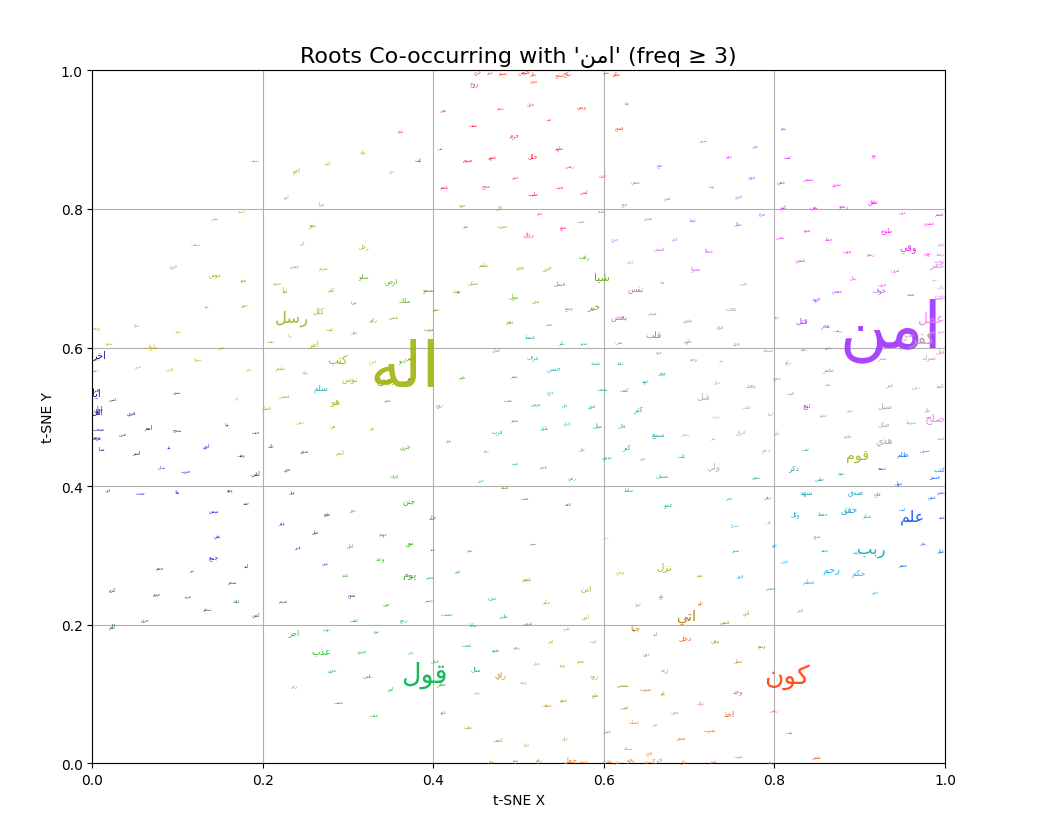

✅ Saved scatter plot to 'output/امن_scatter_cooccur_roots_min3.png'


In [ ]:
# Pattern Power

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import json
import os
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
import arabic_reshaper
from bidi.algorithm import get_display
from adjustText import adjust_text

# ---------------------------
# 1. Configurations
# ---------------------------
frequency_threshold = 3  # ✅ Minimum frequency to include a root in the plot

# ---------------------------
# 2. Load Data Files
# ---------------------------

embedding_file = f"output/{specific_root}_reduced_embeddings_with_cooccur.npy"
roots_file = f"output/{specific_root}_roots_with_cooccur.json"
cooccurrence_file = f"output/{specific_root}_cooccurrence.json"
clusters_file = f"output/{specific_root}_hierarchical_clusters.json"

if not os.path.exists(embedding_file):
    raise FileNotFoundError(f"{embedding_file} not found.")
embeddings = np.load(embedding_file)
print(f"✅ Loaded embeddings: {embeddings.shape}")

with open(roots_file, "r", encoding="utf-8") as f:
    roots_list = json.load(f)

with open(cooccurrence_file, "r", encoding="utf-8") as f:
    co_data = json.load(f)

root_frequencies = {entry["co-stem"]: entry["count"] for entry in co_data.get("cooccurrences", [])}
if "total_occurrences" in co_data:
    root_frequencies[specific_root] = co_data["total_occurrences"]
    print(f"📊 Total frequency of '{specific_root}': {co_data['total_occurrences']}")
else:
    root_frequencies[specific_root] = 1
    print(f"⚠ '{specific_root}' total_occurrences not found, fallback = 1")

with open(clusters_file, "r", encoding="utf-8") as f:
    cluster_data = json.load(f)

# ---------------------------
# 3. Build Cluster Mapping
# ---------------------------
root_to_cluster = {}
for label, stems_dict in cluster_data.items():
    try:
        cluster_id = int(label.split()[1])
    except:
        cluster_id = -1
    for root in stems_dict:
        root_to_cluster[root] = cluster_id

# ---------------------------
# 4. Build Valid Root Lists
# ---------------------------
valid_roots, valid_indices, frequencies, cluster_ids = [], [], [], []
for i, root in enumerate(roots_list):
    if root in root_to_cluster and root in root_frequencies:
        valid_roots.append(root)
        valid_indices.append(i)
        frequencies.append(root_frequencies[root])
        cluster_ids.append(root_to_cluster[root])
    else:
        print(f"⚠ Skipping '{root}' — missing cluster or frequency")

if not valid_indices:
    raise ValueError("No valid roots to plot.")

# ---------------------------
# 5. t-SNE Dimensionality Reduction
# ---------------------------
selected_embeddings = embeddings[valid_indices]
distance_matrix = squareform(pdist(selected_embeddings, metric="euclidean"))

# Use previously defined perplexity if available; otherwise use default
try:
    perplexity
except NameError:
    perplexity = min(10, max(2, len(valid_indices) - 1))
print(f"Using perplexity: {perplexity}")

tsne = TSNE(
    n_components=2,
    metric="precomputed",
    init="random",
    random_state=42,
    perplexity=perplexity,
    max_iter=500
)
tsne_coords = tsne.fit_transform(distance_matrix)

# Normalize t-SNE output to [0, 1]
x = (tsne_coords[:, 0] - tsne_coords[:, 0].min()) / tsne_coords[:, 0].ptp()
y = (tsne_coords[:, 1] - tsne_coords[:, 1].min()) / tsne_coords[:, 1].ptp()
norm_coords = np.column_stack((x, y))

# ---------------------------
# 5b. Repulsion-Based Spacing Adjustment (Soft Relaxation)
# ---------------------------
def apply_min_distance_spacing(coords, min_dist=0.02, steps=10, lr=0.01):
    coords = coords.copy()
    for step in range(steps):
        for i in range(len(coords)):
            for j in range(i + 1, len(coords)):
                dx, dy = coords[i] - coords[j]
                dist = np.sqrt(dx**2 + dy**2)
                if dist < min_dist:
                    force = (min_dist - dist) * lr
                    direction = np.array([dx, dy]) / (dist + 1e-5)
                    coords[i] += direction * force
                    coords[j] -= direction * force
        # Normalize again to [0, 1] each step to keep it bounded
        coords = coords - coords.min(axis=0)
        coords = coords / coords.max(axis=0)
    return coords

norm_coords = apply_min_distance_spacing(norm_coords, min_dist=0.05, steps=20, lr=0.06)
print("✅ Coordinates adjusted with repulsion spacing.")


# ---------------------------
# 6. Filter AFTER t-SNE + Spread Enhancement
# ---------------------------
filtered_roots = []
filtered_coords = []
filtered_freqs = []
filtered_clusters = []

for i, freq in enumerate(frequencies):
    if freq >= frequency_threshold:
        filtered_roots.append(valid_roots[i])
        filtered_coords.append(norm_coords[i])
        filtered_freqs.append(freq)
        filtered_clusters.append(cluster_ids[i])

filtered_coords = np.array(filtered_coords)

# 🔹 Apply spread to improve visual distribution
spread_factor_x = 1.2
spread_factor_y = 1.2
center_x, center_y = 0.5, 0.5
filtered_coords[:, 0] = (filtered_coords[:, 0] - center_x) * spread_factor_x + center_x
filtered_coords[:, 1] = (filtered_coords[:, 1] - center_y) * spread_factor_y + center_y

# ---------------------------
# 7. Cluster Color Mapping
# ---------------------------
unique_clusters = sorted(set(filtered_clusters))
cmap = plt.get_cmap("gist_ncar", len(unique_clusters))

def luminance(color):  # perceived brightness
    r, g, b = mcolors.to_rgb(color)
    return 0.2126 * r + 0.7152 * g + 0.0722 * b

def darken(color, factor=0.7):
    return tuple(np.clip(factor * c, 0, 1) for c in mcolors.to_rgb(color))

def adjust_color(color, threshold=0.65):
    return darken(color) if luminance(color) > threshold else color

cluster_to_color = {cid: adjust_color(cmap(i)) for i, cid in enumerate(unique_clusters)}

# ---------------------------
# 8. Scatter Plot (Using Previously Set Text Parameters)
# ---------------------------
# Use previously defined base_fontsize and scale_factor if available; otherwise, default
try:
    base_fontsize
except NameError:
    base_fontsize = 8
try:
    scale_factor
except NameError:
    scale_factor = 1.2
print(f"Using base_fontsize: {base_fontsize}, scale_factor: {scale_factor}")

plt.figure(figsize=(11, 9))
texts = []

for i, (x, y) in enumerate(filtered_coords):
    root = filtered_roots[i]
    freq = filtered_freqs[i]
    cid = filtered_clusters[i]

    font_size = base_fontsize + scale_factor * freq
    label = get_display(arabic_reshaper.reshape(root))
    color = cluster_to_color.get(cid, "black")
    text = plt.text(x, y, label, fontsize=font_size, color=color, alpha=0.9)
    texts.append(text)

adjust_text(
    texts,
    only_move={'text': 'xy'},
    force_text=70,
    force_points=0.7,
    expand_text=(1.05, 2),
    expand_points=(1.05, 1.2),
    arrowprops=dict(arrowstyle="-", color='grey', lw=0.5, alpha=0.0)
)

title_ar = get_display(arabic_reshaper.reshape(specific_root))
plt.title(f"Roots Co-occurring with '{title_ar}' (freq ≥ {frequency_threshold})", fontsize=16)
plt.xlabel("t-SNE X")
plt.ylabel("t-SNE Y")
plt.grid(True)
plt.xlim(0, 1)
plt.ylim(0, 1)

output_file = f"output/{specific_root}_scatter_cooccur_roots_min{frequency_threshold}.png"
plt.savefig(output_file, dpi=600, bbox_inches="tight")
plt.show()
print(f"✅ Saved scatter plot to '{output_file}'")
